In [41]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.16.1',
 'qiskit-aer': '0.7.2',
 'qiskit-ignis': '0.5.1',
 'qiskit-ibmq-provider': '0.11.1',
 'qiskit-aqua': '0.8.1',
 'qiskit': '0.23.2'}

In [42]:
# -*- coding: utf-8 -*-
"""
Copyright 2018 Alexey Melnikov and Katja Ried.

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License.

Please acknowledge the authors when re-using this code and maintain this notice intact.
Code written by Alexey Melnikov and Katja Ried, implementing ideas from 

'Projective simulation with generalization'
Alexey A. Melnikov, Adi Makmal, Vedran Dunjko & Hans J. Briegel
Scientific Reports 7, Article number: 14430 (2017) doi:10.1038/s41598-017-14740-y
"""

"""
Copyright 2021 Yan-Tong Lin.
Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License.
Please acknowledge the authors when re-using this code and maintain this notice intact.

This is a brand new environment created by Yan-Tong Lin based on the project above.
"""

#This code requires the following packages
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit.library import *
from qiskit import Aer
from qiskit import execute

"""
example of env_config
n_qubit = 2
allowed_gates = [
    (HGate, [0]),
    (HGate, [1]),
    (XGate, [0]),
    (XGate, [1]),
    (ZGate, [0]),
    (ZGate, [1]),
    (CXGate, [0,1]),
]
target_circuit = QuantumCircuit(n_qubit)
target_circuit.h([0,1])
target_circuit.z([0,1])
target_circuit.cz(0,1)
target_circuit.h([0,1])
env_config = (n_qubit, allowed_gates, target_circuit)
"""


class TaskEnvironment(object):
    """
    Quantum Circuit Synthesis Experiment Enviraonment for QML 2020 fall @ Taiwan 
    """
    
    def __init__ (self, config):
        """
        config = (n_qubit, allowed_gates, target_circuit)
        n_qubit: int
        allowed_gates: List[Gate, [bits]]
        target_circuit: QuantumCircuit
        """
        n_qubit, allowed_gates, target_circuit = config
        self.n_qubit = n_qubit
        self.max_steps_per_trial = 10**4
        # self.num_percepts_list = dimensions
        self.current_circuit = QuantumCircuit(self.n_qubit) 
        self.target_circuit = target_circuit
        # Reward is specified by checking equivelance of two circuits --- current and target
        self.act_list = allowed_gates
        #The first entry refers to forbidden x moves, the second to y.
        self.num_actions = len(self.act_list)
    
    def reset(self):
        self.current_circuit = QuantumCircuit(self.n_qubit) 
        return self.current_circuit.qasm(formatted=False)
    
    def move(self,action_index):
        """Given the agent's action index (int 0-3), returns the new position, reward and trial_finished."""
        #test whether the action is permissible   
        action = self.act_list[action_index]
        #Do the Action
        gate, applied = action
        self.current_circuit.append(gate(), applied) # gate() is to instantialize a object from a gate class
        #Test if has reward 
        backend_sim = Aer.get_backend('unitary_simulator')
        job_sim = execute([self.current_circuit, self.target_circuit], backend_sim)
        result_sim = job_sim.result()
        current_unitary = result_sim.get_unitary(self.current_circuit)
        target_unitary = result_sim.get_unitary(self.target_circuit)
        # reward = 1 if (abs(current_unitary-target_unitary) < 1e-5).all() else 0
        reward = np.allclose(current_unitary, target_unitary)
        trial_finished = False
        solution = None
        if reward == 1:  #reset to origin to avoid agent hanging around target all the time
            solution = self.current_circuit
            self.current_circuit = QuantumCircuit(self.n_qubit) 
            trial_finished = True
        return self.current_circuit.qasm(formatted=False), reward, trial_finished, solution

    def get_circuit(self):
        return self.current_circuit
        

In [49]:
# -*- coding: utf-8 -*-
"""
Copyright 2018 Alexey Melnikov and Katja Ried.
Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License.
Please acknowledge the authors when re-using this code and maintain this notice intact.
Code written by Katja Ried
"""

import __future__
import numpy as np
import os# for current directory
import sys # include paths to subfolders for agents and environments
sys.path.insert(0, 'agents')
sys.path.insert(0, 'environments')

"""Import and initialise an environment and an agent.
Different environments or agent types require different arguments, 
as specified in the docstring/help inside the respective files."""

#environment
#import env_quantum_circuit_synthesis
from qiskit import QuantumCircuit
from qiskit.circuit.library import *
n_qubit = 2
allowed_gates = [
    (HGate, [0]),
    (HGate, [1]),
    (XGate, [0]),
    (XGate, [1]),
    (ZGate, [0]),
    (ZGate, [1]),
    (CXGate, [0,1]),
]
target_circuit = QuantumCircuit(n_qubit)
target_circuit.h([0,1])
target_circuit.z([0,1])
target_circuit.cz(0,1)
target_circuit.h([0,1])
env_config = (n_qubit, allowed_gates, target_circuit)
#env = env_quantum_circuit_synthesis.TaskEnvironment(env_config)
env = TaskEnvironment(env_config)
#agent
import ps_agent_flexible
#parameters for the agent - explanations can be found in the comments inside the agent file
ps_eta = 0.5
num_actions, gamma_damping, eta_glow_damping, policy_type, beta_softmax = env.num_actions, 0, ps_eta, 'softmax', 1
agent = ps_agent_flexible.FlexiblePSAgent(env.num_actions, gamma_damping, eta_glow_damping, policy_type, beta_softmax)

In [50]:
target_circuit.qasm(formatted=False)

'OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[2];\nh q[0];\nh q[1];\nz q[0];\nz q[1];\ncz q[0],q[1];\nh q[0];\nh q[1];\n'

In [51]:
target_circuit.draw()

┌───┐┌───┐   ┌───┐
q_0: ┤ H ├┤ Z ├─■─┤ H ├
     ├───┤├───┤ │ ├───┤
q_1: ┤ H ├┤ Z ├─■─┤ H ├
     └───┘└───┘   └───┘

In [55]:
"""Initialise and run interaction"""
#set number of trials and maximum number of steps in each trial
num_trials = 200
max_steps_per_trial = 100 #This doesn't actually matter for invasion_game, which ends every trial after a single step

#initialise a record of performance
learning_curve = np.zeros(num_trials)
step_curve = np.zeros(num_trials)
reward = 0 #temporarily stores the reward for the most recent action

# save circuit found
saved_circuit = None
min_step = max_steps_per_trial


for i_trial in range(num_trials):
    reward_trial = 0 #additive counter of the total rewards earned during the current trial
    discretized_observation = env.reset()
    for t in range(max_steps_per_trial):
        #This is where the heart of the interaction takes place
        action = agent.deliberate_and_learn(discretized_observation, reward)
        discretized_observation, reward, done, solution = env.move(action)
        reward_trial += reward
        if done:
            if t < min_step:
                saved_circuit = solution
                min_step = t
            break
    learning_curve[i_trial] = float(reward_trial)/(t+1)
    step_curve[i_trial] = (t+1)


In [56]:
saved_circuit.draw()

┌───┐┌───┐     ┌───┐┌───┐┌───┐┌───┐┌───┐
q_0: ┤ X ├┤ H ├──■──┤ Z ├┤ X ├┤ X ├┤ Z ├┤ H ├
     ├───┤└───┘┌─┴─┐└───┘└───┘└───┘└───┘└───┘
q_1: ┤ X ├─────┤ X ├─────────────────────────
     └───┘     └───┘

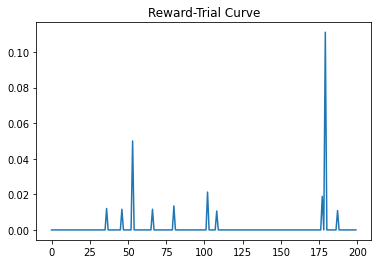

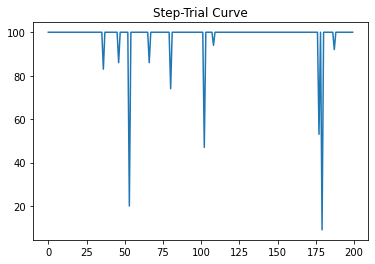

In [57]:
"""Return results"""
import matplotlib.pyplot as plt
plt.title("Reward-Trial Curve")
plt.plot(learning_curve)
plt.show()
plt.title("Step-Trial Curve")
plt.plot(step_curve)
plt.show()

In [40]:
"""
test append with gate can work
"""
qc = QuantumCircuit(2) 
gates = [HGate, CXGate]
qc.append(gates[0](), [0])
qc.append(gates[1](), [0,1])
qc.draw()

┌───┐     
q_0: ┤ H ├──■──
     └───┘┌─┴─┐
q_1: ─────┤ X ├
          └───┘